In [1]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )


from FIA import *
from ML4com import *

# TensorFlow and tf.keras
import tensorflow as tf
import keras
from keras import layers, activations


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
info_dir = "../../data/comm8_self"
data_dir = "../../runs/FIA/comm8/oms"
run_dir = "../../runs/ML/try"

info_dir = os.path.normpath(os.path.join(os.getcwd(), info_dir))
data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

strains = pd.read_csv(os.path.join(info_dir, "strains.tsv"), sep="\t")
comm8 = pd.read_csv(os.path.join(info_dir, "comm8.tsv"), sep="\t")

fia_df = load_fia_df(data_dir, file_ending=".mzML", separator="\t")

Loading names:


100%|██████████| 72/72 [00:00<?, ?it/s]


Loading experiments:


100%|██████████| 68/68 [00:00<00:00, 85.59it/s]


In [ ]:
# binned_dfs = bin_df_stepwise_batch(fia_df, binning_var="mz", binned_var="inty", statistic="sum", start=50.0, stop=1700.0, step=0.002)
# binned_dfs.to_csv(os.path.join(run_dir, "data_matrix.tsv"), sep="\t")
binned_dfs = pd.read_csv(os.path.join(run_dir, "data_matrix_oms.tsv"), sep="\t", index_col="mz", engine="pyarrow")

In [ ]:
scaler = MaxAbsScaler()
binned_dfs[:] =  scaler.fit_transform(binned_dfs)

In [ ]:
print(binned_dfs.shape)
print(comm8.shape)
print(strains.shape)

(825000, 68)
(68, 8)
(8, 1)


## Model definition

In [ ]:
model = keras.Sequential(name="MS_community_prediction")
model.add(keras.layers.Masking(mask_value=0.))                                                  # Masking zeros
model.add(layers.Dense(512, activation=activations.tanh, name="Feature_combination_1"))
# model.add(layers.Dense(128, activation=activations.relu, name="Feature_combination_2"))
model.add(layers.Dense(128,  activation=activations.relu, name="Feature_interpretation_1"))
# model.add(layers.Dense(128,  activation=activations.relu, name="Feature_interpretation_2"))
model.add(layers.Dense(8,  activation=activations.softmax, name="Decision"))

## Splitting dataset

In [ ]:
X = binned_dfs.transpose()
y = comm8

test_index = sample_without_replacement(68, math.ceil(68/5))
test_data  = X.iloc[test_index]
test_labels = y.iloc[test_index]

kf = KFold(n_splits = 5)     # stratified: skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

## Compiling

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

## Training

In [ ]:
for train_index, val_index in kf.split(X, y):
	training_data = X.iloc[train_index]
	training_labels = y.iloc[train_index]
	validation_data = X.iloc[val_index]
	validation_labels = y.iloc[val_index]

	model.fit(training_data, training_labels, epochs=10)
	test_loss, test_acc = model.evaluate(validation_data,  validation_labels, verbose="auto")
	
	predictions = model.predict(test_data)

Epoch 1/10
2/2 [==============================] - 4s 1s/step - loss: 9.5125 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 8/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 9/10
2/2 [==============================] - 3s 1s/step - loss: 9.5124 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 104ms/step
Epoch 1/10
2/2 [============================

: 

: 

In [ ]:
def sns_plot(x, y, hue=None, size=None, xlim: Optional[List[float]] = None, ylim: Optional[List[float]] = None,
            plottype: str = "line", log:List[str]=[], sizes:Optional[Tuple[int, int]]=(20,20), palette:str="hls",
            figsize:Optional[Tuple[int,int]] = (18, 5), ax=None) -> None:
    """
    Shows a plot of a spectrum between the defined borders
    @spectrum: pyopenms.MSSpectrum
    @xlim: list of two positions
    @plottype: "line" | "scatter"
    returns: None, but displays plot
    """
    plt.figure(figsize = figsize)
    if plottype == "line":
        sns.lineplot(x=y, y=y, hue=hue, size=size, ax=ax) # type: ignore
    elif plottype == "scatter":
        sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore
    else:
        sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore

    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    if "y" in log:
        plt.yscale('log')
    if "x" in log:
        plt.xscale('log')
    plt.show()

In [ ]:
def plot_spec_label(i, test_data, ax):
  ms_peaks =  test_data.iloc[i]
  sns_plot(ms_peaks.index, ms_peaks.values, plottype="scatter", sizes=(1,1), figsize=(12,3), ax=ax)

def plot_value_array(i, predictions, test_labels, labels):
  plt.grid(False)
  plt.yticks([])
  plt.xticks(range(8) ,labels=labels, rotation=45)
  plot = plt.bar(range(8), predictions, color="#777777")
  plt.ylim([0, 1])
  for pos, val in enumerate(test_labels.iloc[i].values):
    if val == 1.0:
      plot[pos].set_color('blue')



C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


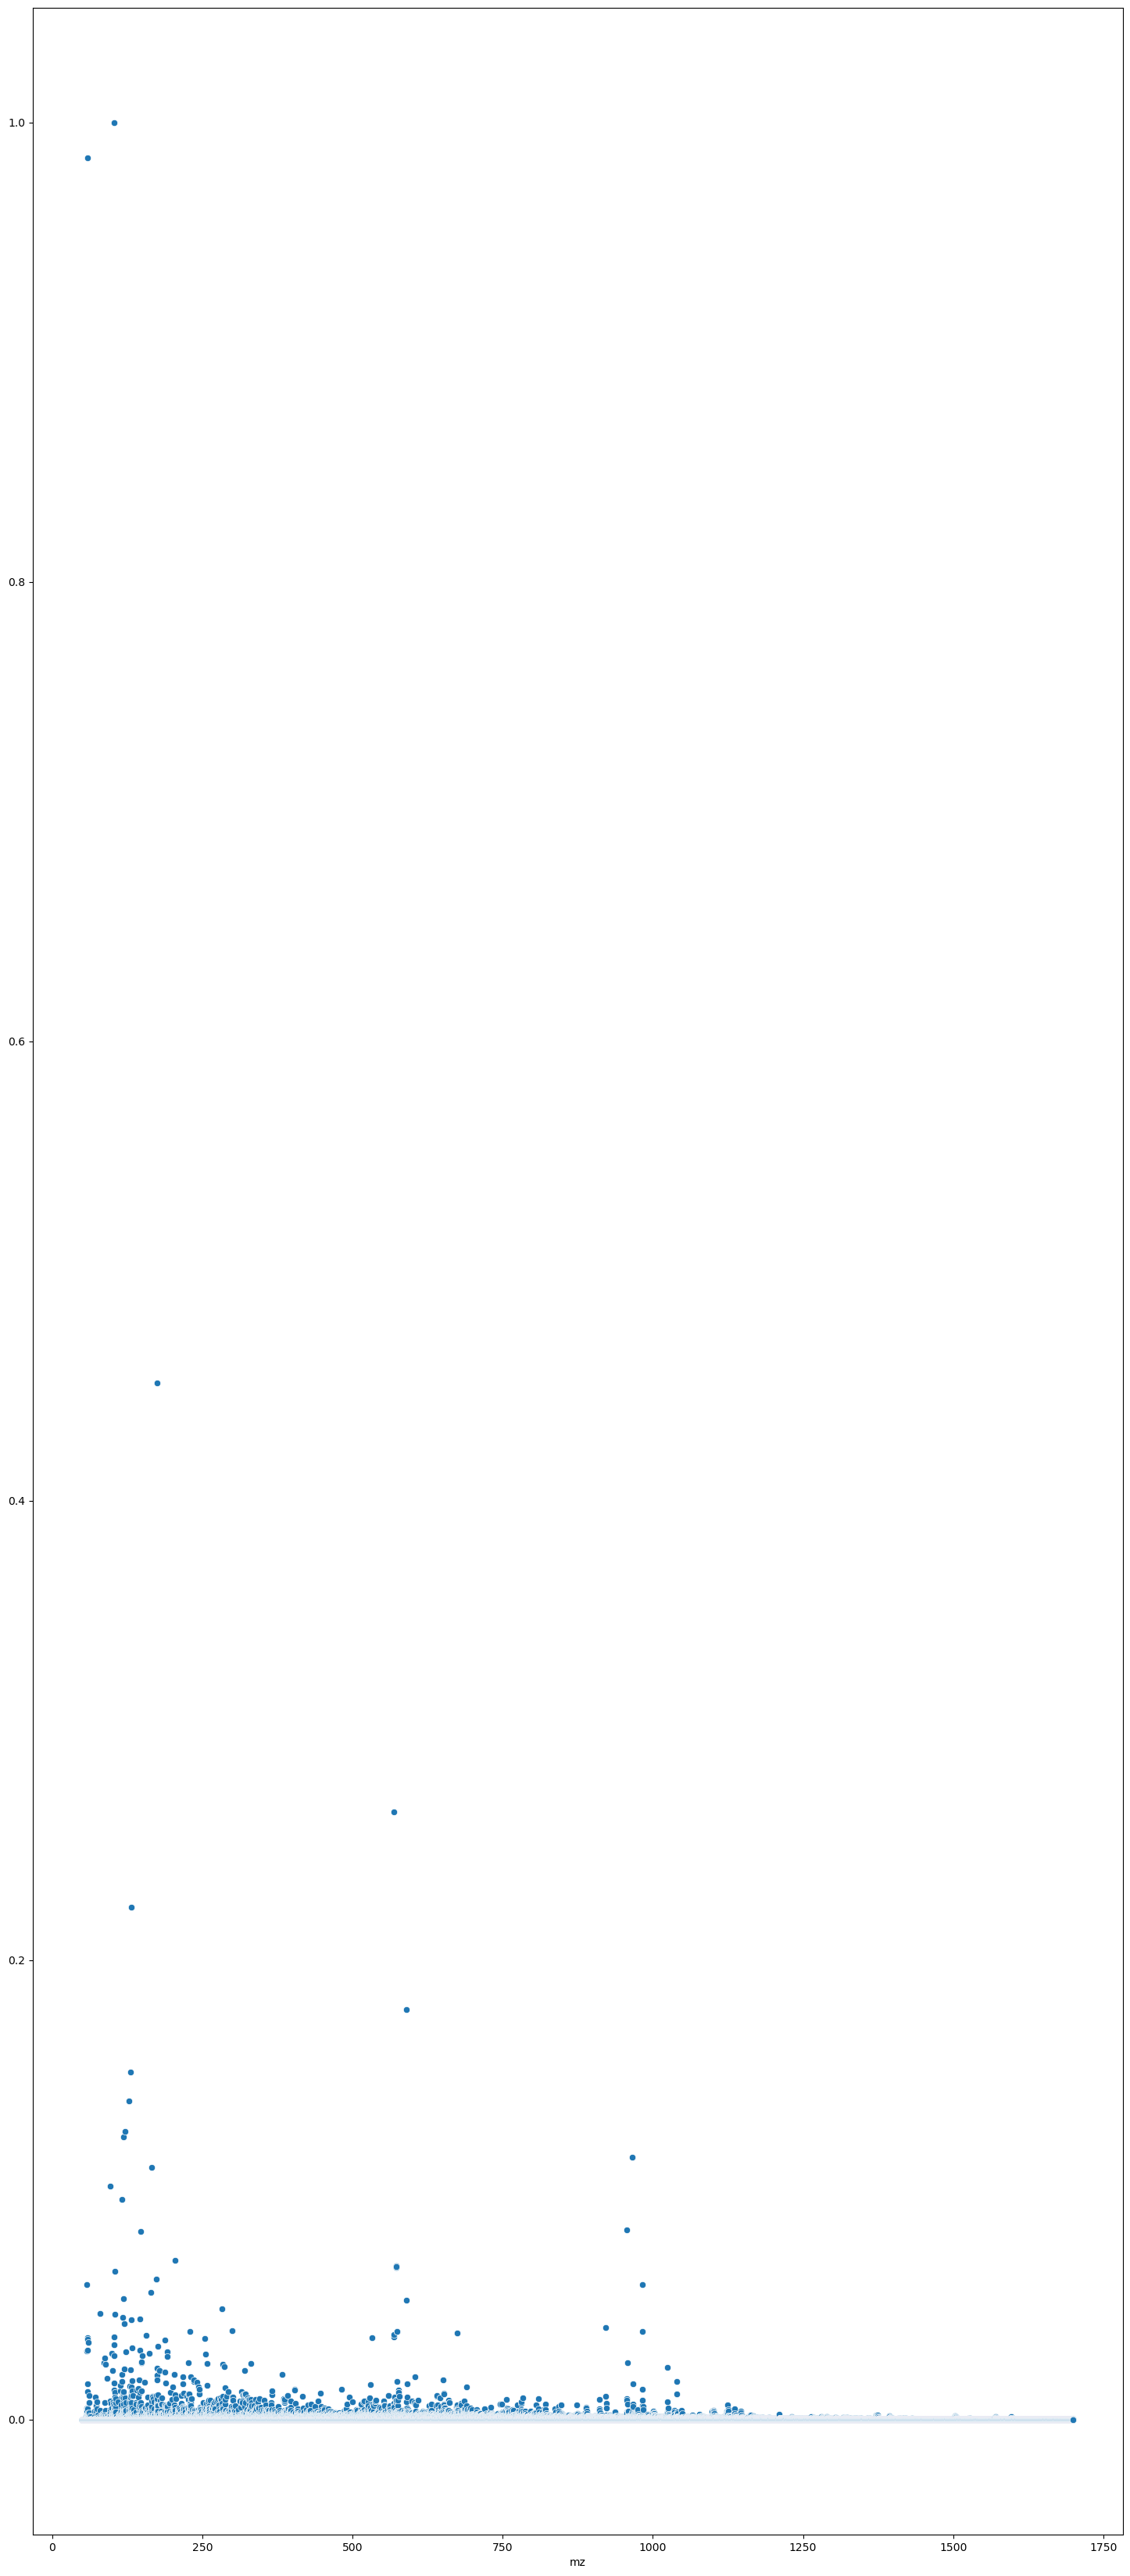

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


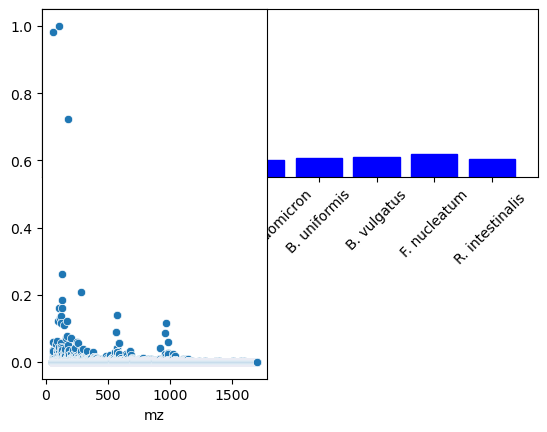

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


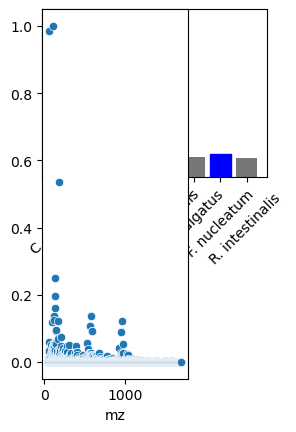

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


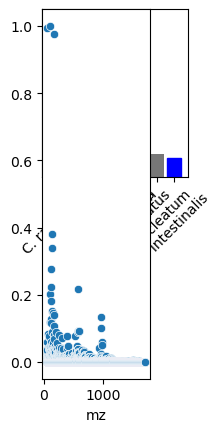

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


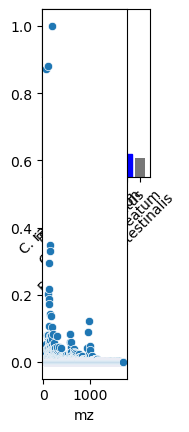

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


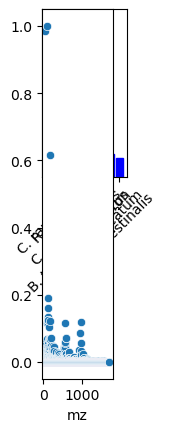

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


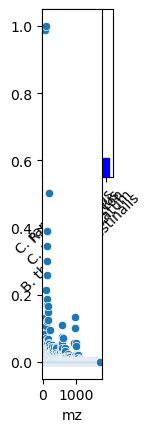

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


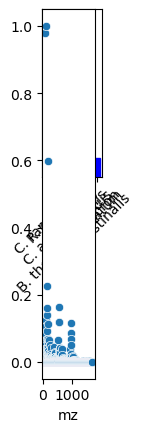

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


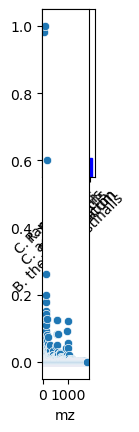

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


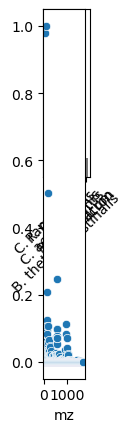

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


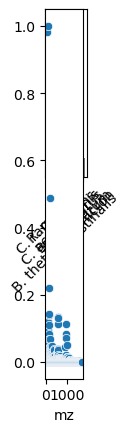

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


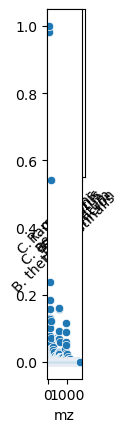

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


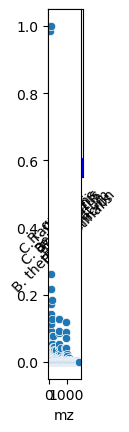

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\763925910.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette, ax=ax)  # type: ignore


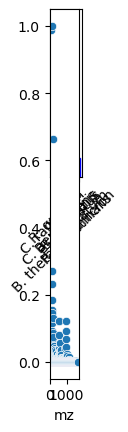

<Figure size 1200x300 with 0 Axes>

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_10496\2065753685.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


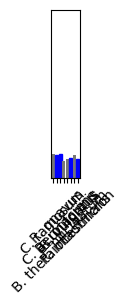

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
plt.figure(figsize=(18, len(test_labels)*3))
for i in range(len(test_labels)):
  ax = plt.subplot(1, i+1, 1)
  plot_spec_label(i, test_data, ax)
  plt.subplot(2, i+1, 1)
  plot_value_array(i, predictions[i], test_labels, list(strains.values.flatten()))
plt.tight_layout()
plt.show()